In [ ]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz
!tar xzf fgvc-aircraft-2013b.tar.gz
!mv fgvc-aircraft-2013b dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2625M  100 2625M    0     0  28.1M      0  0:01:33  0:01:33 --:--:-- 28.5M


# Importation

In [ ]:
import datetime
import pathlib

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import tensorflow as tf
import yaml

from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

From a the file `parameter.yaml`, I import name of the target variable, the paths used and the size of the images in input.

In [ ]:
with open('parameters.yaml') as file:
    P = yaml.load(file)

TARGET_NAME = P['TARGET_NAME']
DATA_DIR = pathlib.Path(P['DIR']['DATA_DIR'])
MODELS_DIR = pathlib.Path(P['DIR']['MODELS_DIR'])
IMAGE_WIDTH = P['IMAGE_DIM']['IMAGE_WIDTH']
IMAGE_HEIGHT = P['IMAGE_DIM']['IMAGE_HEIGHT']
IMAGE_DEPTH = P['IMAGE_DIM']['IMAGE_DEPTH']

The function `p` is only useful to manage the verbose. It is used to display the time of the comments allowing the user to observe the progress of the code.

In [ ]:
def p(msg, lvl):
  d = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")
  return print(d, "\t"*lvl, msg)

The function `build_x_and_y` allows to create the set of features and the dependent variable. It also resizes images and the argument `two_dim` allows to specify if the model used needs a two dimensional set of features or not (for a SVM model for example).

In [ ]:
def build_x_and_y(path, target, width, height, two_dim = False):
  """Build x tensor and y tensor for model fitting.

  Parameters
  ----------
  path (Path): path pattern to read csv file containing images information.
  target (str): name of the target column.
  width (int): width of the resized image.
  height (int): height of the resized image.
  two_dim (bool): indicate if the features must be returned into a two dimensional set

  Returns
  -------
  X (np.array): tensor of x values.
  Y (np.array): tensor of y values.
  label (pd.Series): label corresponding to the y values
  """
  p(f"Building X and Y from the path : {path}", 1)
  p("Loading data", 2)
  _df = pd.read_csv(path, sep='\t', names=['all'], dtype={'all': str})

  p(f"Creation of classes {target}", 2)
  _df['image_id'] = _df['all'].apply(lambda x: x.split(' ')[0])
  _df[target] = _df['all'].apply(lambda x: ' '.join(x.split(' ')[1:]))

  p("Importing image paths", 2)
  _df['path'] = _df['image_id'].apply(lambda x: pathlib.Path('dataset/data/images') / (x + '.jpg'))

  p(f"Resizing images (width = {width}, height = {height})", 2)
  _df['resized_image'] = _df.apply(lambda r: np.array(Image.open(r['path']).resize((width, height))), axis=1)

  p(f"Creation of X and Y", 2)
  X = np.array(_df['resized_image'].to_list())
  Y = tf.keras.utils.to_categorical(_df[target].astype('category').cat.codes)
  labels = _df[target]

  if two_dim:
    X = X.reshape(len(X), -1)
    Y = np.array(labels)

  p(f"...X and Y created !", 1)
  return X, Y, labels

The function `build_classification_model` allows to create a classification model from a specific convolutional neural network.

In [ ]:
def build_classification_model(X, Y):
  """Build a TF model using set of features and labels

  Parameters
  ----------
  X (np.array): tensor of x values.
  Y (np.array): tensor of y values.

  Returns
  -------
  TF model built and compiled
  """
  p("Building classification model", 1)
  nb_classes = len(Y[0]) # Compute number of classes for output layer
  size = X[0].shape # Compute images size for input layer

  #Building the model
  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=size))
  model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(rate=0.5))
  model.add(Dense(nb_classes, activation='softmax')) # output layer with nb_classes

  #Compilation of the model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  p("...Model created !", 1)

  return model

# Convolutional Neural Network

From the specified target name, I build the train and test set of features and of variable of interest.

In [ ]:
X_train, y_train, labels_train = build_x_and_y(DATA_DIR / ('images_' + TARGET_NAME + '_train.txt'), TARGET_NAME, IMAGE_WIDTH, IMAGE_HEIGHT)
X_test, y_test, labels_test = build_x_and_y(DATA_DIR / ('images_' + TARGET_NAME + '_test.txt'), TARGET_NAME, IMAGE_WIDTH, IMAGE_HEIGHT)

06/04/2022 13:44:38 	 Building X and Y from the path : dataset/data/images_manufacturer_train.txt
06/04/2022 13:44:38 		 Loading data
06/04/2022 13:44:38 		 Creation of classes manufacturer
06/04/2022 13:44:38 		 Importing image paths
06/04/2022 13:44:38 		 Resizing images (width = 128, height = 128)
06/04/2022 13:46:08 		 Creation of X and Y
06/04/2022 13:46:08 	 ...X and Y created !
06/04/2022 13:46:08 	 Building X and Y from the path : dataset/data/images_manufacturer_test.txt
06/04/2022 13:46:08 		 Loading data
06/04/2022 13:46:08 		 Creation of classes manufacturer
06/04/2022 13:46:08 		 Importing image paths
06/04/2022 13:46:08 		 Resizing images (width = 128, height = 128)
06/04/2022 13:47:35 		 Creation of X and Y
06/04/2022 13:47:35 	 ...X and Y created !


Configuring the TPU

In [ ]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Running on TPU  ['10.104.220.154:8470']
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.104.220.154:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.104.220.154:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


I build the classification model through a convolutional neural network.

In [ ]:
with tpu_strategy.scope():
  model_CNN = build_classification_model(X_train, y_train)

06/04/2022 13:47:44 	 Building classification model
06/04/2022 13:47:45 	 ...Model created !


Model training with 30 epochs.

In [ ]:
%%time
epochs = 30
history = model_CNN.fit(X_train, y_train, batch_size=96, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/30
35/35 [==============================] - 39s 804ms/step - loss: 35.8510 - accuracy: 0.1599 - val_loss: 3.2528 - val_accuracy: 0.2202
Epoch 2/30
35/35 [==============================] - 3s 83ms/step - loss: 3.0556 - accuracy: 0.2172 - val_loss: 2.9591 - val_accuracy: 0.2202
Epoch 3/30
35/35 [==============================] - 3s 84ms/step - loss: 2.9528 - accuracy: 0.2178 - val_loss: 2.8568 - val_accuracy: 0.2208
Epoch 4/30
35/35 [==============================] - 3s 83ms/step - loss: 2.8701 - accuracy: 0.2142 - val_loss: 2.7685 - val_accuracy: 0.2166
Epoch 5/30
35/35 [==============================] - 3s 90ms/step - loss: 2.7301 - accuracy: 0.2415 - val_loss: 2.7459 - val_accuracy: 0.2214
Epoch 6/30
35/35 [==============================] - 3s 86ms/step - loss: 2.5907 - accuracy: 0.2543 - val_loss: 2.6373 - val_accuracy: 0.2292
Epoch 7/30
35/35 [==============================] - 3s 87ms/step - loss: 2.4350 - accuracy: 0.2771 - val_loss: 2.5625 - val_accuracy: 0.2352
Epoch 8/30

I save the model and the labels in order to reuse it in a streamlit application.

In [ ]:
model_CNN.save(f'{MODELS_DIR}/CNN_{TARGET_NAME}_.h5')

In [ ]:
labels = labels_test.astype('category').cat.categories.tolist()

with open('labels_' + TARGET_NAME + '.yaml', 'w') as f:
    data = yaml.dump(labels, f)

# Support Vector Machine

Because SVM needs a two dimensional set of features, I reshape the train and test sets.

In [ ]:
X_train2, y_train2 = X_train.reshape(len(X_train), -1), np.array(labels_train)
X_test2, y_test2 = X_test.reshape(len(X_test), -1), np.array(labels_test)

I add some preprocessing step before implementing the SVM. Firstly, I scale the features by removing the mean and scaling to the unit. Secondly, I extract the 500 first components from a PCA analysis. Then, I implement a linear SVC.

In [ ]:
model_SVM = Pipeline([
('scaler', StandardScaler()),
('pca', PCA(n_components=500)),
('SVC', SVC(kernel='linear', gamma='auto', probability=True))
])

In [ ]:
model_SVM.fit(X_train2, y_train2)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=500)),
                ('SVC', SVC(gamma='auto', kernel='linear', probability=True))])

I save the model.

In [ ]:
pickle.dump(model_SVM, open(f'{MODELS_DIR}/SVM_{TARGET_NAME}_.pkl', 'wb'))

# Evaluation

The next code allows to compare the confusion matrix on the test set: CNN vs SVM

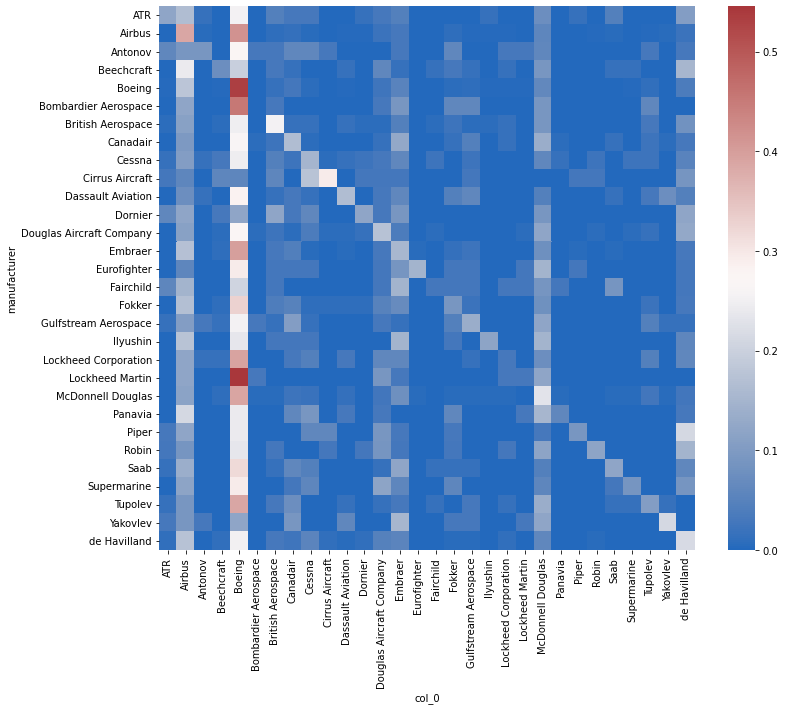

In [ ]:
proba_CNN = model_CNN.predict(X_test)
classe_CNN = np.argmax(proba_CNN, axis=1)
lab_classe_CNN = np.array(labels_test.astype('category').cat.categories[classe_CNN])

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(pd.crosstab(labels_test,
                        lab_classe_CNN,
                        normalize='index'),
            cmap='vlag',
            ax=ax);

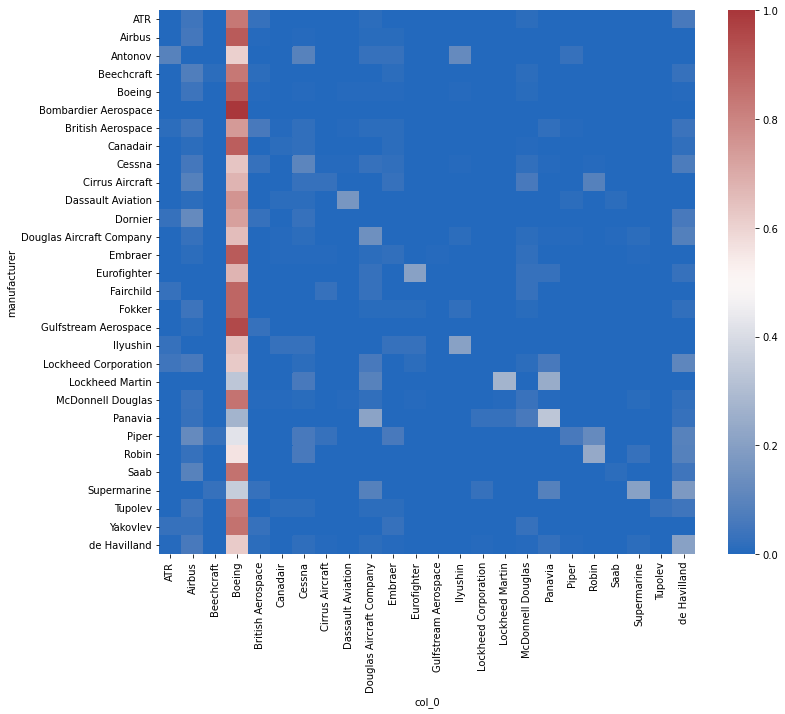

In [ ]:
proba_SVM = model_SVM.predict_proba(X_test2)
classe_SVM = np.argmax(proba_SVM, axis=1)
lab_classe_SVM = np.array(labels_test.astype('category').cat.categories[classe_SVM])

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(pd.crosstab(labels_test,
                        lab_classe_SVM,
                        normalize='index'),
            cmap='vlag',
            ax=ax);

In [ ]:
print(f"Accuracy du modèle CNN : {round(100*np.mean(lab_classe_CNN == labels_test), 2)} %")
print(f"Accuracy du modèle SVM : {round(100*np.mean(lab_classe_SVM == labels_test), 2)} %")

Accuracy du modèle CNN : 26.73 %
Accuracy du modèle SVM : 25.44 %


# Essais pour streamlit

In [ ]:
proba_CNN = model_CNN.predict(X_test)
classe_CNN = np.argmax(proba_CNN, axis=1)
lab_classe_CNN = np.array(labels_test.astype('category').cat.categories[classe_CNN])

In [ ]:
model_CNN.predict(X_test[1,:,:,:])

In [ ]:
!pip uninstall matplotlib

Found existing installation: matplotlib 3.5.1
Uninstalling matplotlib-3.5.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.1-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? ERROR: Operation cancelled by user


In [ ]:
!pip install matplotlib==3.5.1

In [ ]:
import matplotlib

In [ ]:
np.char.add(np.round(proba_CNN[1,:]*100, 2).astype('str'), "%")

array(['0.0%', '14.4%', '0.0%', '0.13%', '50.59%', '0.0%', '0.17%',
       '0.05%', '0.01%', '0.0%', '0.12%', '0.04%', '0.03%', '0.04%',
       '0.1%', '0.0%', '0.03%', '0.28%', '0.0%', '0.05%', '0.05%',
       '2.19%', '0.0%', '0.0%', '0.0%', '28.68%', '0.43%', '0.19%',
       '0.04%', '2.37%'], dtype='<U33')

AttributeError: ignored

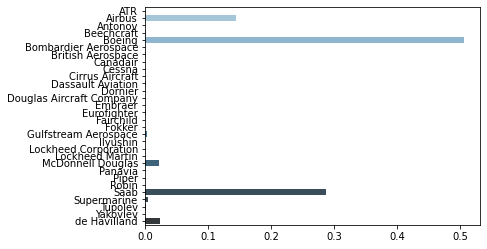

In [ ]:
ax = sns.barplot(y=labels, x=proba_CNN[1,:], palette="Blues_d")
ax.bar_label(ax.containers[0])